1. use spearman correlation between OTUs and 5 VitD variables (with BH FDR corrected p-val <= 0.05 as threshold)
2. use lasso regression on all OTUs vs. 5 VitD variables (need Cross-validation to choose tuning parameter)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

## Spearman correlation

### merge biomtable with mapping file (output: dat)

In [2]:
mf = pd.read_csv('../data/mapping_cleaned_MrOS.txt', sep='\t', dtype=str, index_col='#SampleID')
bt = pd.read_csv('../data/biomtable.txt', sep='\t', dtype=str, index_col='#OTU ID')  
bt = bt.transpose()

In [3]:
print(mf.shape, bt.shape) # bt has an additional row of 'taxonomy'

(599, 66) (600, 4727)


In [4]:
mf.head()

,BarcodeSequence,LinkerPrimerSequence,Experiment_Design_Description,Library_Construction_Protocol,Linker,Platform,Center_Name,Center_Project,Instrument_Model,Title,...,OHV1D2,OHV1D2CT,OHVD2CT,OHVDTOT,OHV1DTOT,OHSEAS,VDstatus,Description,ratio_activation,ratio_catabolism
#SampleID,,,,,,,,,,,,,,,,,,,,,
BI0023,TCTGGTGACATT,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,1: Yes,1: Yes,25.8,0.039299999999999995,3:SUMMER,sufficiency,Orwoll.BI0023.BI,0.0015232558139534882,0.0686046511627907
BI0056,CAAGCATGCCTA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,1: Yes,1: Yes,39.2,0.0619,2:SPRING,sufficiency,Orwoll.BI0056.BI,0.001579081632653061,0.09974489795918368
BI0131,CTATTTGCGACA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,1: Yes,1: Yes,23.1,0.0521,2:SPRING,sufficiency,Orwoll.BI0131.BI,0.002255411255411255,0.06450216450216449
BI0153,ATCGGCGTTACA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,1: Yes,1: Yes,27.3,0.0431,2:SPRING,sufficiency,Orwoll.BI0153.BI,0.0015787545787545787,0.07838827838827839
BI0215,CCTCTCGTGATC,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,1: Yes,1: Yes,33.0,0.0502,4:FALL,sufficiency,Orwoll.BI0215.BI,0.0015212121212121212,0.1096969696969697


In [5]:
bt.head()

#OTU ID,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGTGTAGGCGGGATATCAAGTCAGAAGTGAAAATTACGGGCTCAACTCGTAACCTGCTTTTGAAACTGACATTCTTGAGTGAAGTAGAGGCAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGGCTTTTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGACGGGTCCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGGACCTTGAGTGCGGCAGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGACCGTAACTGACGTTGATGCTCGAAAGTGCGGGTATCAAA,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAA,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAA,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAA,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTGTCTTGAGTACAGTAGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGACTGTAACTGACGCTGATGCTCGAAAGTGTGGGTATCAAA,TACGGAGGATTCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATTTCGGGGCTCAACCCTGAACGTGCCTCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGGTGTAGCGGTGAAATGCTTAGAGATCATACAGAACACCGATTGCGAAGGCAGCTTACCAAACTATATCTGACGTTGAGGCACGAAAGCGTGGGGAGCAAA,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTCAGATAAGTTAGAGGTGAAATTCCGGTGCTTAACACCGGCGCTGCCTCTAATACTGTTTGACTAGAGAGTAGTTGCGGTAGGCGGAATGTATGGTGTAGCGGTGAAATGCTTAGAGATCATACAGAACACCGATTGCGAAGGCAGCTTACCAAGCTATATCTGACGTTGAGGCACGAAAGCGTGGGGAGCAAA,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGTGTAGGTGGCATCACAAGTCAGAAGTGAAAGCCCGGGGCTCAACCCCGGGACTGCTTTTGAAACTGTGGAGCTGGAGTGCAGGAGAGGCAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAA,...,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGTTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGACCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAGGCAAGTCAGATGTGAAAACCCGGGGCTCAACTCCGGGACTGCATTTGAAACTGTCTAGCTAGAGTGCAGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCATAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGACGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTGTTGCTAGAGTGCTGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTTACTGGACAGTAACTGACGTTGAGGCTCGAAAACGTGGGGAGCAAA,TACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGCTTGGTAAGTCAGGGGTGAAATCCCACAGCCCAACTATGGAACTGCCTTTGATACTGCCAGGCTTGAGTACCGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACACCGGTGGCGAAGGCGGCCACCTGGACGGTAACTGACGCTGAGGTGCGAAAGCGTGGGTAGCAAA,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGTGCGCAGGCGGGATTGCAAGTTGGATGTGAAATACCGGGGCTTAACCCCGGAGCTGCATCCAAAACTGTAGTTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCGAGTGTAGCGGTGAAATGCGTAGATATTCGGAGGAACACCAGCGGCGAAGGCGGCTTACTGGGCTCTAACTGACGCTGAGGCACGAAAGCATGGGTAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTCTTGTAAGTCCGGTGTGAAAACCCGAGGCTCAACCTCGGGACTGCACTGGAAACTATGGGACTGGAGTGTCGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGACAACTGACGCTGAGGCTCGAAAGCG

In [6]:
dat = pd.merge(mf, bt, left_index=True, right_index=True)

In [7]:
dat.shape

(599, 4793)

In [8]:
dat.head()

,BarcodeSequence,LinkerPrimerSequence,Experiment_Design_Description,Library_Construction_Protocol,Linker,Platform,Center_Name,Center_Project,Instrument_Model,Title,...,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGTTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGACCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAGGCAAGTCAGATGTGAAAACCCGGGGCTCAACTCCGGGACTGCATTTGAAACTGTCTAGCTAGAGTGCAGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCATAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGACGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTGTTGCTAGAGTGCTGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTTACTGGACAGTAACTGACGTTGAGGCTCGAAAACGTGGGGAGCAAA,TACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGCTTGGTAAGTCAGGGGTGAAATCCCACAGCCCAACTATGGAACTGCCTTTGATACTGCCAGGCTTGAGTACCGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACACCGGTGGCGAAGGCGGCCACCTGGACGGTAACTGACGCTGAGGTGCGAAAGCGTGGGTAGCAAA,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGTGCGCAGGCGGGATTGCAAGTTGGATGTGAAATACCGGGGCTTAACCCCGGAGCTGCATCCAAAACTGTAGTTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCGAGTGTAGCGGTGAAATGCGTAGATATTCGGAGGAACACCAGCGGCGAAGGCGGCTTACTGGGCTCTAACTGACGCTGAGGCACGAAAGCATGGGTAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTCTTGTAAGTCCGGTGTGAAAACCCGAGGCTCAACCTCGGGACTGCACTGGAAACTATGGGACTGGAGTGTCGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGACAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGGATTTAAGTCAGCGGTGAAAGTTTGAGGCTCAACCTTAAAATTGCCGTTGAAACTGGGTTTCTTGAGTGTATTTGAAGTAGGCGGAATTCGTTGTGTAGCGGTGAAATGCATAGATATAACGAAGAACTCCAATTGCGCAGGCAGCTTACTAAACTACAACTGACGCTGAAGCACGAAAGCGTGGGTATCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCAGAAGTGAAAACCCCGGGCTTAACCTGGGGACTGCTTTTGAAACTGTTTGGCTGGAGTGCAGGAGAGGTGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGAGACAAGTTGAATGTCTAAACTATCGGCTTAACTGATAGTCGCGTTCAAAACTATCACTCTTGAGTGCAGTAGAGGTAGGCAGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAAC,TACGTAGGGGGCAAGAGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCATGACAAGCCAGATGTGAAAACCCAGGGCTCAACCCTGGGACTGCATTTGGAACTGCCAGGCTGGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAA
BI0023,TCTGGTGACATT,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0056,CAAGCATGCCTA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0131,CTATTTGCGACA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0153,ATCGGCGTTACA,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0215,CCTCTCGTGATC,GGACTACHVGGGTWTCTAAT,16S stool samples sequenced for MrOS Vitamin D...,16S rRNA v4,GT,Illumina,BI,MrOS,Illumina MiSeq,MrOS_VitaminD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
vars_vd = np.array(['OHVD3', 'OHV1D3', 'OHV24D3', 'ratio_activation', 'ratio_catabolism'])
dat[vars_vd] = dat[vars_vd].apply(pd.to_numeric, errors='coerce')

In [10]:
dat[vars_vd].describe()

,OHVD3,OHV1D3,OHV24D3,ratio_activation,ratio_catabolism
count,556.000000,567.000000,567.000000,556.000000,556.000000
mean,35.229137,0.057775,3.430864,0.001772,0.094776
std,12.450758,0.019773,1.834771,0.000735,0.029770
min,7.800000,0.010700,0.300000,0.000398,0.018788
25%,27.400000,0.044100,2.175000,0.001316,0.074216
50%,33.650000,0.055500,3.180000,0.001660,0.092821
75%,41.825000,0.066300,4.235000,0.002081,0.112849
max,104.000000,0.156000,14.070000,0.006727,0.197786


### correlation

In [11]:
otu_cols = dat.columns[mf.shape[1]:dat.shape[1]]
len(otu_cols)

4727

#### OHVD3

In [12]:
results= []
i = 0
for j in range(len(otu_cols)):
    tmp = dat[[vars_vd[i], otu_cols[j]]].dropna(axis=0, how='any')
    rho, pval = spearmanr(tmp[vars_vd[i]], tmp[otu_cols[j]])
    tax = bt.loc['taxonomy'][otu_cols[j]]
    results.append([vars_vd[i], otu_cols[j], tax, rho, pval])

# output table    
results = pd.DataFrame(results, columns=['vars', 'otu', 
                                         'taxonomy', 'rho', 'pval']).dropna(axis=0, how='any')
results['fdr pval'] = multipletests(results['pval'], method = 'fdr_bh')[1]
results = results.sort_values(['fdr pval'], ascending=True)

# specific bacteria
index = results.loc[results['fdr pval'] <= 0.05].index
for i in range(len(index)):
    print(results.taxonomy[index[i]], results['fdr pval'][index[i]])

In [13]:
# check
results.head(5)

,vars,otu,taxonomy,rho,pval,fdr pval
2334,OHVD3,TACGTAGGGAGCAAGCGTTGTCCGGATTCACTGGGCGTAAAGAGCA...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.109423,0.009820,0.826241
2734,OHVD3,TACGTAGGGGGCGAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.074962,0.077383,0.826241
2721,OHVD3,TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.068540,0.106439,0.826241
2703,OHVD3,TACGTAGGTGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.126345,0.002841,0.826241
2701,OHVD3,TACGTAGGGGGCAAGTGTTATCCGGATTTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.069011,0.104050,0.826241


###### OHV1D3

In [14]:
results_spearman_OHV1D3 = []
i = 1
for j in range(len(otu_cols)):
    tmp = dat[[vars_vd[i], otu_cols[j]]].dropna(axis=0, how='any')
    rho, pval = spearmanr(tmp[vars_vd[i]], tmp[otu_cols[j]])
    tax = bt.loc['taxonomy'][otu_cols[j]]
    results_spearman_OHV1D3.append([vars_vd[i], otu_cols[j], tax, rho, pval])

# output table    
results_spearman_OHV1D3 = pd.DataFrame(results_spearman_OHV1D3, columns=['vars', 'otu', 'taxonomy', 'rho', 
                                                           'pval']).dropna(axis=0, how='any')
results_spearman_OHV1D3['fdr pval'] = multipletests(results_spearman_OHV1D3['pval'], method = 'fdr_bh')[1]
results_spearman_OHV1D3 = results_spearman_OHV1D3.sort_values(['fdr pval'], ascending=True)

# specific bacteria
index_OHV1D3 = results_spearman_OHV1D3.loc[results_spearman_OHV1D3['fdr pval'] <= 0.05].index
for i in range(len(index_OHV1D3)):
    print(results_spearman_OHV1D3.taxonomy[index_OHV1D3[i]],
          results_spearman_OHV1D3['rho'][index_OHV1D3[i]],
          results_spearman_OHV1D3['fdr pval'][index_OHV1D3[i]])

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia; s__ -0.199859878038 0.00752977206365
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__ 0.175859458122 0.0284551114051
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__ 0.17598295019 0.0284551114051
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Christensenellaceae; g__; s__ 0.176234965806 0.0284551114051
k__Bacteria; p__Tenericutes; c__RF3; o__ML615J-28; f__; g__; s__ 0.17245893348 0.0284551114051
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__ 0.1741285045 0.0284551114051
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Lachnospira; s__ 0.170018992582 0.0315087394734
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__ 0.165885498221 0.0422056869211
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridi

In [15]:
# check
results_spearman_OHV1D3.head(10)

,vars,otu,taxonomy,rho,pval,fdr pval
808,OHV1D3,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.199860,0.000002,0.007530
0,OHV1D3,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.175859,0.000025,0.028455
237,OHV1D3,TACGTAGGTGGCGAGCGTTGTCCGGAATGACTGGGCGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.175983,0.000025,0.028455
289,OHV1D3,TACGTAGGGGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.176235,0.000024,0.028455
315,OHV1D3,TACATAGGGGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGTG...,k__Bacteria; p__Tenericutes; c__RF3; o__ML615J...,0.172459,0.000037,0.028455
341,OHV1D3,TACGTAGGGGGCGAGCGTTGTCCGGAATGACTGGGCGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.174129,0.000031,0.028455
62,OHV1D3,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.170019,0.000047,0.031509
524,OHV1D3,TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.165885,0.000072,0.042206
389,OHV1D3,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.162297,0.000104,0.048481
346,OHV1D3,TACGTAGGGGGCAAGCGTTGTCCGGAATGATTGGGCGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.162295,0.000104,0.048481


#### OHV24D3

In [16]:
results= []
i = 2
for j in range(len(otu_cols)):
    tmp = dat[[vars_vd[i], otu_cols[j]]].dropna(axis=0, how='any')
    rho, pval = spearmanr(tmp[vars_vd[i]], tmp[otu_cols[j]])
    tax = bt.loc['taxonomy'][otu_cols[j]]
    results.append([vars_vd[i], otu_cols[j], tax, rho, pval])

# output table    
results = pd.DataFrame(results, columns=['vars', 'otu', 
                                         'taxonomy', 'rho', 'pval']).dropna(axis=0, how='any')
results['fdr pval'] = multipletests(results['pval'], method = 'fdr_bh')[1]
results = results.sort_values(['fdr pval'], ascending=True)

# specific bacteria
index = results.loc[results['fdr pval'] <= 0.05].index
for i in range(len(index)):
    print(results.taxonomy[index[i]], 
          results['rho'][index[i]],
          results['fdr pval'][index[i]])

k__Bacteria; p__Firmicutes; c__Erysipelotrichi; o__Erysipelotrichales; f__Erysipelotrichaceae; g__; s__ 0.190355708167 0.0234067706265


In [17]:
# check
results.head(3)

,vars,otu,taxonomy,rho,pval,fdr pval
557,OHV24D3,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGG...,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,0.190356,0.000005,0.023407
369,OHV24D3,TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.150416,0.000325,0.506989
509,OHV24D3,TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.154249,0.000227,0.506989


#### ratio_activation

In [18]:
results= []
i = 3
for j in range(len(otu_cols)):
    tmp = dat[[vars_vd[i], otu_cols[j]]].dropna(axis=0, how='any')
    rho, pval = spearmanr(tmp[vars_vd[i]], tmp[otu_cols[j]])
    tax = bt.loc['taxonomy'][otu_cols[j]]
    results.append([vars_vd[i], otu_cols[j], tax, rho, pval])

# output table    
results = pd.DataFrame(results, columns=['vars', 'otu', 
                                         'taxonomy', 'rho', 'pval']).dropna(axis=0, how='any')
results['fdr pval'] = multipletests(results['pval'], method = 'fdr_bh')[1]
results = results.sort_values(['fdr pval'], ascending=True)

# specific bacteria
index = results.loc[results['fdr pval'] <= 0.05].index
for i in range(len(index)):
    print(results.taxonomy[index[i]], 
          results['rho'][index[i]],
          results['fdr pval'][index[i]])

k__Bacteria; p__Actinobacteria; c__Coriobacteriia; o__Coriobacteriales; f__Coriobacteriaceae; g__Collinsella; s__aerofaciens 0.205430869768 0.00480556475164
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Bifidobacteriales; f__Bifidobacteriaceae; g__Bifidobacterium; s__adolescentis 0.18657996033 0.0219326446641
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Coprococcus; s__ 0.182982414424 0.0219326446641
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales 0.17632798806 0.0224875187164
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__ 0.17667163223 0.0224875187164
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__; s__ 0.176468273107 0.0224875187164
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia; s__ -0.169605546227 0.032013016431
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__ 0.170988997592 0

In [19]:
# store result for future check with lasso
results_spearman_activation = results

In [20]:
# check
results.head(10)

,vars,otu,taxonomy,rho,pval,fdr pval
83,ratio_activation,TACGTAGGGGGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCG...,k__Bacteria; p__Actinobacteria; c__Coriobacter...,0.205431,0.000001,0.004806
758,ratio_activation,TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCT...,k__Bacteria; p__Actinobacteria; c__Actinobacte...,0.186580,0.000009,0.021933
822,ratio_activation,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.182982,0.000014,0.021933
50,ratio_activation,TACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.176328,0.000029,0.022488
538,ratio_activation,TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.176672,0.000028,0.022488
573,ratio_activation,TACGTAGGGGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.176468,0.000029,0.022488
2372,ratio_activation,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.169606,0.000058,0.032013
826,ratio_activation,TACGTAGGGAGCGAGCGTTATCCGGAATTATTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.170989,0.000051,0.032013
330,ratio_activation,TACGTAGGTGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.169022,0.000062,0.032013
230,ratio_activation,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.166615,0.000079,0.036744


#### ratio_catabolism

In [21]:
results= []
i = 4
for j in range(len(otu_cols)):
    tmp = dat[[vars_vd[i], otu_cols[j]]].dropna(axis=0, how='any')
    rho, pval = spearmanr(tmp[vars_vd[i]], tmp[otu_cols[j]])
    tax = bt.loc['taxonomy'][otu_cols[j]]
    results.append([vars_vd[i], otu_cols[j], tax, rho, pval])

# output table    
results = pd.DataFrame(results, columns=['vars', 'otu', 
                                         'taxonomy', 'rho', 'pval']).dropna(axis=0, how='any')
results['fdr pval'] = multipletests(results['pval'], method = 'fdr_bh')[1]
results = results.sort_values(['fdr pval'], ascending=True)

# specific bacteria
index = results.loc[results['fdr pval'] <= 0.05].index
for i in range(len(index)):
    print(results.taxonomy[index[i]], 
          results['fdr pval'][index[i]])

In [22]:
# check
results.head(3)

,vars,otu,taxonomy,rho,pval,fdr pval
557,ratio_catabolism,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGG...,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,0.181890,0.000016,0.074166
369,ratio_catabolism,TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.170042,0.000056,0.129824
204,ratio_catabolism,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.164678,0.000096,0.148595


## Lasso Regression

1. reference on lasso: https://www.coursera.org/learn/machine-learning-data-analysis/supplement/MMg4w/python-code-lasso-regression
2. reference on standardize data before lasso: https://chrisalbon.com/machine-learning/lasso_regression_in_scikit.html
3. no need for standardization on OTUs, as they are on the same scale already

In [23]:
tmp = dat[np.append(vars_vd, otu_cols)].dropna()
print(tmp.shape)
tmp.head()

(556, 4732)


,OHVD3,OHV1D3,OHV24D3,ratio_activation,ratio_catabolism,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGTGTAGGCGGGATATCAAGTCAGAAGTGAAAATTACGGGCTCAACTCGTAACCTGCTTTTGAAACTGACATTCTTGAGTGAAGTAGAGGCAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGGCTTTTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGACGGGTCCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGGACCTTGAGTGCGGCAGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGACCGTAACTGACGTTGATGCTCGAAAGTGCGGGTATCAAA,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAA,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAA,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAA,...,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGTTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGACCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAGGCAAGTCAGATGTGAAAACCCGGGGCTCAACTCCGGGACTGCATTTGAAACTGTCTAGCTAGAGTGCAGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCATAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGACGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTGTTGCTAGAGTGCTGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTTACTGGACAGTAACTGACGTTGAGGCTCGAAAACGTGGGGAGCAAA,TACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGCTTGGTAAGTCAGGGGTGAAATCCCACAGCCCAACTATGGAACTGCCTTTGATACTGCCAGGCTTGAGTACCGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACACCGGTGGCGAAGGCGGCCACCTGGACGGTAACTGACGCTGAGGTGCGAAAGCGTGGGTAGCAAA,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGTGCGCAGGCGGGATTGCAAGTTGGATGTGAAATACCGGGGCTTAACCCCGGAGCTGCATCCAAAACTGTAGTTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCGAGTGTAGCGGTGAAATGCGTAGATATTCGGAGGAACACCAGCGGCGAAGGCGGCTTACTGGGCTCTAACTGACGCTGAGGCACGAAAGCATGGGTAGCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTCTTGTAAGTCCGGTGTGAAAACCCGAGGCTCAACCTCGGGACTGCACTGGAAACTATGGGACTGGAGTGTCGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGACAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGGATTTAAGTCAGCGGTGAAAGTTTGAGGCTCAACCTTAAAATTGCCGTTGAAACTGGGTTTCTTGAGTGTATTTGAAGTAGGCGGAATTCGTTGTGTAGCGGTGAAATGCATAGATATAACGAAGAACTCCAATTGCGCAGGCAGCTTACTAAACTACAACTGACGCTGAAGCACGAAAGCGTGGGTATCAAA,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCAGAAGTGAAAACCCCGGGCTTAACCTGGGGACTGCTTTTGAAACTGTTTGGCTGGAGTGCAGGAGAGGTGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAA,TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGAGACAAGTTGAATGTCTAAACTATCGGCTTAACTGATAGTCGCGTTCAAAACTATCACTCTTGAGTGCAGTAGAGGTAGGCAGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAAC,TACGTAGGGGGCAAGAGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCATGACAAGCCAGATGTGAAAACCCAGGGCTCAACCCTGGGACTGCATTTGGAACTGCCAGGCTGGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAA
BI0023,25.8,0.0393,1.77,0.001523,0.068605,0.0,0.0,223.0,4071.0,313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BI0056,39.2,0.0619,3.91,0.001579,0.099745,88.0,0.0,120.0,5639.0,0.0,...,0.0,0

#### OHVD3

In [24]:
X = tmp[otu_cols]
y = tmp[vars_vd[0]]

# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(X, y, test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=True).fit(pred_train,tar_train)


In [25]:
np.sum(model.coef_)

0.0

#### OHV1D3

In [26]:
X = tmp[otu_cols]
y = tmp[vars_vd[0]]

# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(X, y, test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=True).fit(pred_train,tar_train)

In [27]:
np.sum(model.coef_)

0.0

#### OHV24D3

In [28]:
X = tmp[otu_cols]
y = tmp[vars_vd[0]]

# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(X, y, test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=True).fit(pred_train,tar_train)

In [29]:
np.sum(model.coef_)

0.0

#### ratio_activation

In [30]:
X = tmp[otu_cols]

# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(X, y, test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=20, precompute=True).fit(pred_train,tar_train)

In [31]:
np.sum(model.coef_)

0.0

In [32]:
reg = dict(zip(X.columns, model.coef_))
reg = pd.DataFrame.from_dict(reg, orient='index').rename(
    columns={0: 'lasso coef'})
reg['taxonomy'] = bt.loc['taxonomy'][reg.index]

In [33]:
subset = reg.loc[reg['lasso coef'] != 0]
print(subset.shape)
print(subset.taxonomy.values, subset['lasso coef'].values)

(0, 2)
[] []


In [34]:
# store result for future need
subset_activation = subset
subset_activation

,lasso coef,taxonomy


In [35]:
# check whether the same as in spearman result 
same = results_spearman_activation.loc[results_spearman_activation['otu'].isin (subset_activation.index)]
print(same.taxonomy.values)
print(same['fdr pval'])

[]
Series([], Name: fdr pval, dtype: float64)


In [36]:
results_spearman_activation.loc[results['fdr pval'] <= 0.05].index

Int64Index([], dtype='int64')

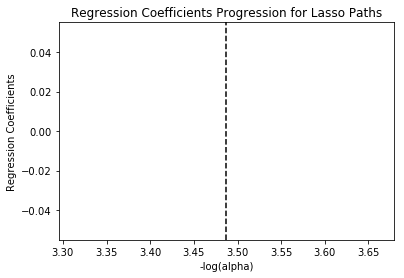

In [48]:
# plot coefficient progression
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
#plt.savefig('../figures/lasso_coef.png', bbox_inches='tight')

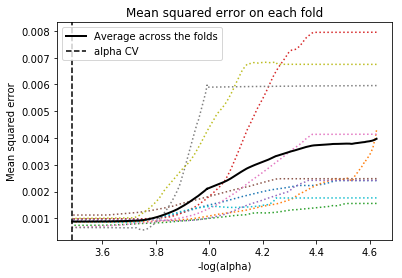

In [47]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
#plt.savefig('../figures/lasso_mse.png', bbox_inches='tight')

In [49]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
0.000873019224696
test data MSE
0.000911886138733


In [50]:
# R-square from training and test data
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.0
test data R-square
-0.000300931903442


#### ratio_catabolism

In [51]:
X = tmp[otu_cols]
y = tmp[vars_vd[4]]

# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(X, y, test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=True).fit(pred_train,tar_train)

In [52]:
np.sum(model.coef_)

0.0

In [53]:
# check
reg = dict(zip(X.columns, model.coef_))
reg = pd.DataFrame.from_dict(reg, orient='index').rename(
    columns={0: 'lasso coef'})
reg['taxonomy'] = bt.loc['taxonomy'][reg.index]
subset = reg.loc[reg['lasso coef'] != 0]
print(subset.shape)

(0, 2)


In [44]:
#### previous scratch on lasso

In [45]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [46]:
small= tmp[np.append(vars_vd[1], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[1]]

NameError: name 'scaler' is not defined

In [ ]:
# drop all missing values
tmp = dat[np.append(vars_vd, otu_cols)]
tmp.head()

In [ ]:
scaler = StandardScaler()
small= tmp[np.append(vars_vd[0], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[0]]
names = otu_cols

In [ ]:
# Create a function called lasso,
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()

    # Create a column of feature names
    df['OTU names'] = names

    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)

        # Fit the lasso regression
        lasso.fit(X, Y)

        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_

    # Return the datafram    
    return df

In [ ]:
table = lasso([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [ ]:
table.head()

In [ ]:
table.loc[table['Alpha = 0.500000'] != 0]

In [ ]:
list = np.array([63, 131, 188, 237, 384, 505, 2116, 2545, 3484, 3598])
for i in range(len(list)):
    print(bt.loc['taxonomy'][list[i]])

In [ ]:
scaler = StandardScaler()
small= tmp[np.append(vars_vd[1], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[1]]
names = otu_cols

In [ ]:
table = lasso([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [ ]:
table.loc[table['Alpha = 3.000000'] != 0]

In [ ]:
bt.loc['taxonomy'][3323]

In [ ]:
scaler = StandardScaler()
small= tmp[np.append(vars_vd[2], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[2]]
names = otu_cols
table = lasso([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [ ]:
table.loc[table['Alpha = 2.000000'] != 0]

In [ ]:
scaler = StandardScaler()
small= tmp[np.append(vars_vd[3], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[3]]
names = otu_cols
table = lasso([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [ ]:
table.loc[table['Alpha = 2.000000'] != 0]

In [ ]:
scaler = StandardScaler()
small= tmp[np.append(vars_vd[3], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[3]]
names = otu_cols
table = lasso([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [ ]:
table.loc[table['Alpha = 1.000000'] != 0]

In [ ]:
scaler = StandardScaler()
small= tmp[np.append(vars_vd[4], otu_cols)].dropna(axis=0, how='any')
X = scaler.fit_transform(small[otu_cols])
Y = small[vars_vd[4]]
names = otu_cols
table = lasso([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

In [ ]:
table.loc[table['Alpha = 1.000000'] != 0]

In [ ]:
clf = Lasso(alpha=0.5)
clf.fit(X, Y)
Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
print(clf.coef_)

In [ ]:
sum(np.abs(clf.coef_))

In [ ]:
print(clf.intercept_)